In [21]:
# Standard python imports
import os
import h5py
import numpy as np
import scipy.stats
from tqdm import tqdm, tnrange, tqdm_notebook

# Keras, tf, and sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Try seeing if we are using a gpu?
from keras import backend as K
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(sess)
print("Using gpu: ", K.tensorflow_backend._get_available_gpus())

# Make reproducible
SEED = 32
np.random.seed(SEED)
tf.set_random_seed(SEED)

# My module imports
import utils
from models import model_1d

import matplotlib.pyplot as plt
%matplotlib inline

Using gpu:  []


In [4]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

# Import the data from file
f = h5py.File("data.mat")
data, labels = np.array(f['data']), np.array(f['labels'])
f.close()

In [5]:
# Get rid of zero columns
colInds = np.sum(data, axis=0) != 0.0
data = data[:, colInds]

# Labels are off by 1 cuz matlab
labels = labels - 1

In [23]:
def jensen_shannon(ps, weights=None):
    if weights is None:
        weights = np.full(len(ps), 1 / len(ps))
    tot = np.max([len(p) for p in ps])
    ps = np.array([np.concatenate((p, np.zeros(tot - p.shape[0]))) for p in ps])
    ps = ps / np.sum(ps, axis=1)[:, None]
    t1 = scipy.stats.entropy(np.sum(ps * weights[:, None], axis=0))
    t2 = np.dot(weights, [scipy.stats.entropy(p) for p in ps])
    return t1 - t2

def gene_relevance_metric(gene_vals, labels):
    counts = [gene_vals[labels == l] for l in np.unique(labels)]
    distributions = [np.bincount(val) for val in counts]
    return jensen_shannon(distributions)

In [25]:
%timeit gene_relevance_metric(data[:, 0].astype(int), labels.squeeze().astype(int))

578 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
data_f = data.astype(int)
labels_f = labels.squeeze().astype(int)
gene_scores = np.array([gene_relevance_metric(data_f[:, i], labels_f) for i in tnrange(data_f.shape[1])])

In [27]:
gene_scores

array([0.00354302, 0.00034544, 0.00269851, ..., 0.00067114, 0.01083506,
       0.01366661])

In [35]:
inds = np.argsort(gene_scores)[::-1]

In [36]:
data_shuffled = data[:, inds]
data_shuffled = np.log1p(data_shuffled)

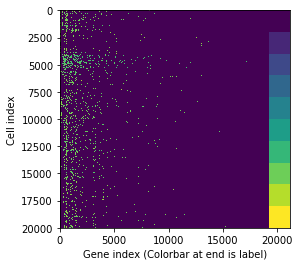

In [37]:
# Visualize data with labels
labels_scaled = labels * (data_shuffled.max() - data_shuffled.min()) / labels.max() - data_shuffled.min()
plt.imshow(np.hstack((data_shuffled, np.repeat(labels_scaled, data.shape[1] //  10, axis=1))))
plt.xlabel("Gene index (Colorbar at end is label)")
plt.ylabel("Cell index");